<Axes: xlabel='timestamp'>

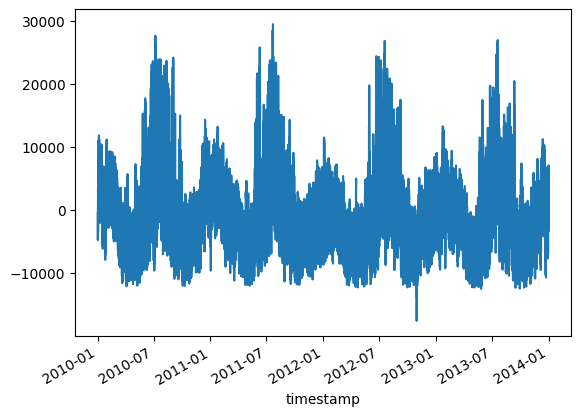

In [38]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LinearRegression
REGION = 'PJME'
df = pd.read_csv(f"data/raw/{REGION}_hourly.csv")

# df = df.iloc[:20000]
df = df.rename(columns={'Datetime':'timestamp', f'{REGION}_MW': 'load_mw'})
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp').reset_index(drop=True)
df = df.set_index('timestamp')

doy = df.index.day_of_year
df['dow'] = df.index.day_of_week
df["sin_doy"] = np.sin(2 * np.pi * doy /365)
df["cos_doy"] = np.cos(2 * np.pi * doy /365)
df["sin_2_doy"] = np.sin(4 * np.pi * doy /365)
df["cos_2_doy"] = np.cos(4 * np.pi * doy /365)
df["sin_dow"] = np.sin(2 * np.pi * dow /365)
df["cos_dow"] = np.cos(2 * np.pi * dow /365)

df = df.loc['2010':'2013']
df['load_mw'] -= df['load_mw'].mean()
df['load_mw'].plot()





np.float64(2945.604247474773)

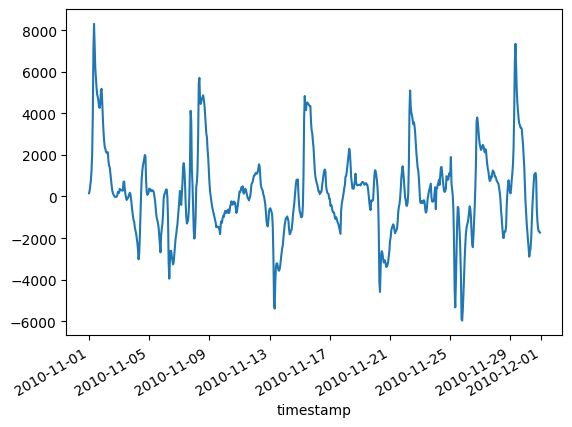

In [39]:
from scipy.stats import kurtosis

df['res24'] = (df['load_mw'] - df['load_mw'].shift(24)).dropna()
df['res24'].loc['2010-11'].plot()
df['res24'].std()


In [41]:
import numpy as np
import torch
def build_res24_dataset(series, window=48):
    """
    series : pandas Series of res24 values (already dropna'd)
    returns X, y as numpy arrays ready for PyTorch
    X shape = (N, window)
    y shape = (N, 1)
    """
    values = series.values
    X, y = [], []

    for i in range(len(values) - window):
        X.append(values[i : i + window])
        y.append(values[i + window])  # predict next res24

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32).reshape(-1, 1)
    return X, y

res = df['res24'].dropna()
mean = res.mean()
std = res.std()

res_norm = (res - mean) / std


X, y = build_res24_dataset(res_norm, window=168)
X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(y)

from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)



In [42]:
import torch
import torch.nn as nn


class MLPForecast(nn.Module):
    def __init__(self,window=48):
        super().__init__()
        self.window = window
        self.fc1 = nn.Linear(window,window)
        self.fc2 = nn.Linear(window,1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))
    
    




In [45]:
def forecast_res24_sequence(model, res_norm, window=48):
    """
    model: trained PyTorch model
    res_norm: normalized res24 series (pandas Series)
    returns: array of predicted normalized res24
    """
    model.eval()
    preds = []

    values = res_norm.values

    # generate predictions from window → end
    for i in range(window, len(values)):
        window_input = values[i-window:i]  # last 48 values
        x = torch.tensor(window_input, dtype=torch.float32).unsqueeze(0)  # shape (1, window)
        with torch.no_grad():
            pred = model(x).item()
        preds.append(pred)

    return np.array(preds)

# window = 168

# pred_norm = forecast_res24_sequence(model, res_norm, window=window)
# pred_res24 = pred_norm * std + mean

# start = window
# end = len(res_norm)

# actual_res24 = res.iloc[window : window + len(pred_res24)]



# import matplotlib.pyplot as plt

# N = 240  # number of samples you want to visualize

# actual_slice = actual_res24.iloc[:N]
# pred_slice   = pred_res24[:N]
# time_slice   = actual_slice.index

# plt.figure(figsize=(12,5))
# plt.plot(time_slice, actual_slice.values, label='Actual res24')
# plt.plot(time_slice, pred_slice, label='Predicted res24')
# plt.legend()
# plt.title(f'MLP Forecast of res24 (first {N} samples)')
# plt.show()


In [47]:
def forecast_res24_multistep(model, start_window_norm, steps):
    """
    model : trained PyTorch model
    start_window_norm : 1D numpy array of the last `window` normalized res24 values
    steps : how many future hours to predict

    Returns: normalized predictions of length `steps`
    """
    model.eval()
    preds = []

    cur_window = start_window_norm.copy()
    window = len(cur_window)

    for _ in range(steps):
        x = torch.tensor(cur_window, dtype=torch.float32).unsqueeze(0)  # shape (1, window)
        with torch.no_grad():
            pred_norm = model(x).item()
        preds.append(pred_norm)

        # Shift window: drop oldest, add predicted value
        cur_window = np.append(cur_window[1:], pred_norm)

    return np.array(preds)


def reconstruct_load_from_res24(pred_res24, df_load, last_timestamp, steps):
    """
    pred_res24 : array of predicted res24 (denormalized)
    df_load : full load series (df['load_mw'])
    last_timestamp : timestamp of the last OBSERVED load in df_load
    steps : number of hours ahead you forecast

    Returns: array of predicted load, length = steps
    """

    pred_load = []

    # Extract the last 24 actual load values
    last_24_actual = df_load.loc[
        last_timestamp - pd.Timedelta(hours=23) : last_timestamp
    ].values

    for k in range(steps):

        if k < 24:
            # Use ACTUAL lag-24 load values
            lag24_value = last_24_actual[k]
        else:
            # Use our OWN predicted load from k-24
            lag24_value = pred_load[k - 24]

        # Reconstruct load
        load_hat = pred_res24[k] + lag24_value
        pred_load.append(load_hat)

    return np.array(pred_load)


0 0.6666823625564575
1 1.0523204803466797
2 0.4777947962284088
3 0.4286581873893738
4 0.33415815234184265
5 0.7512775659561157
6 0.37924373149871826
7 0.33859914541244507
8 0.43546175956726074
9 0.2913987636566162
10 0.4513700306415558
11 0.4273422956466675
12 0.29175183176994324
13 0.3325939178466797
14 0.28455737233161926
15 0.2513470947742462
16 0.47251540422439575
17 0.14174330234527588
18 0.2029847949743271
19 0.3284994065761566


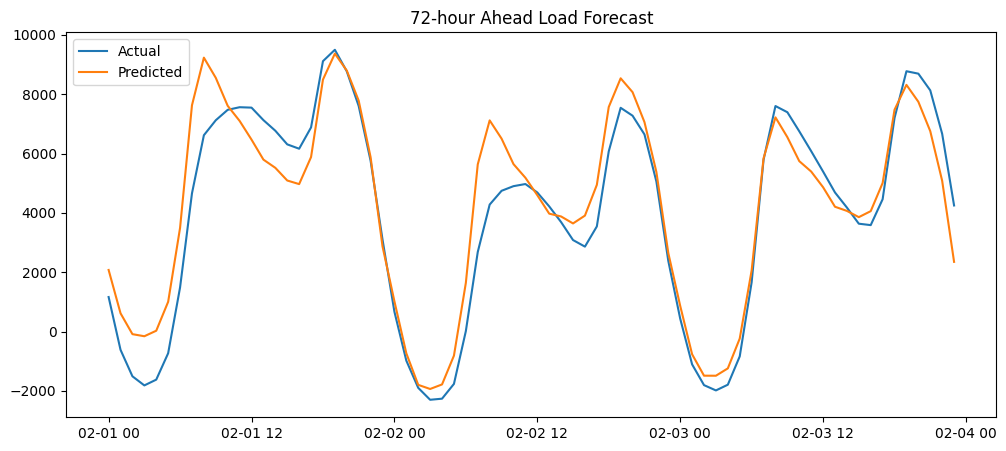

In [49]:
import matplotlib.pyplot as plt

res = df['res24'].dropna()

train_res = res.loc['2008':'2010']
test_res  = res.loc['2011-01']

mean = train_res.mean()
std = train_res.std()

train_norm = (train_res - mean) / std
test_norm  = (test_res - mean) / std

# ---------------- FIX 1: correct training dataset ----------------
X_train, y_train = build_res24_dataset(train_norm, window=168)

X_tensor = torch.from_numpy(X_train)
y_tensor = torch.from_numpy(y_train)

train_loader = DataLoader(TensorDataset(X_tensor, y_tensor),
                          batch_size=64, shuffle=True)

model = MLPForecast(window=168)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()
for epoch in range(20):
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
    print(epoch, loss.item())


# ---------------- Forecasting ----------------

steps = 72

# Start window from test series
start_window = test_norm.values[-168:]

pred_norm = forecast_res24_multistep(model, start_window, steps)
pred_res24 = pred_norm * std + mean

# ---------------- FIX 2: correct last timestamp ----------------
last_ts = test_res.index[-1]     # <<<<< Correct

pred_load = reconstruct_load_from_res24(
    pred_res24,
    df['load_mw'],
    last_ts,
    steps
)

# ---------------- Actual future load ----------------
actual_load = df['load_mw'].loc[
    last_ts + pd.Timedelta(hours=1) :
    last_ts + pd.Timedelta(hours=steps)
]

# ---------------- Plot ----------------
plt.figure(figsize=(12,5))
plt.plot(actual_load.index, actual_load.values, label="Actual")
plt.plot(actual_load.index, pred_load, label="Predicted")
plt.legend()
plt.title(f"{steps}-hour Ahead Load Forecast")
plt.show()


In [52]:
print(np.std(actual_load.values-pred_load)/np.std(actual_load.values))


0.30635712337901005
